In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
traindata = pd.read_csv("train.csv")
testdata = pd.read_csv("test.csv")
traindata.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Obviously there is a need to drop "PassengerId" and "Name" columns because they do not affect "Survived" column

In [3]:
traindata.drop(["PassengerId", "Name"], axis = 1, inplace = True)
traindata.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S


Due to the ratio between count of Cabin NaNs and count of rows may be it is optimal to drop Cabin to improve model quality. But we will try that later

In [4]:
print(traindata.shape)
traindata.isnull().sum()


(891, 10)


Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

The volume of unique values of ticket column is too huge, perhaps it does not contain core information:

In [5]:
traindata = traindata.drop("Ticket", axis = 1)

Applying one-hot encoding for columns with string values, nans and int categorical marks:

In [6]:
columns_to_encode = ["Sex", "Cabin", "Embarked"]

In [7]:
trainencoded = pd.concat([pd.get_dummies(traindata[columns_to_encode], dummy_na = True), traindata.drop(columns_to_encode, axis =1)], axis = 1)

In [8]:
trainencoded

,Sex_female,Sex_male,Sex_nan,Cabin_A10,Cabin_A14,Cabin_A16,Cabin_A19,Cabin_A20,Cabin_A23,Cabin_A24,...,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,3,22.0,1,0,7.2500
1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1,38.0,1,0,71.2833
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,3,26.0,0,0,7.9250
3,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,35.0,1,0,53.1000
4,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,3,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,2,27.0,0,0,13.0000
887,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,19.0,0,0,30.0000
888,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,3,NaN,1,2,23.4500
889,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1,26.0,0,0,30.0000


No outliers detected:

In [9]:
traindata.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Age column contains NaN values. Replacing with mean of ages:

In [10]:
trainencoded["Age"].fillna(trainencoded["Age"].mean(), inplace = True)

<h4> Concerning correlations between values:</h4>

SibSp has high correlation with Parch and Fare level correlates positively with probabilyty to survive:

<AxesSubplot:>

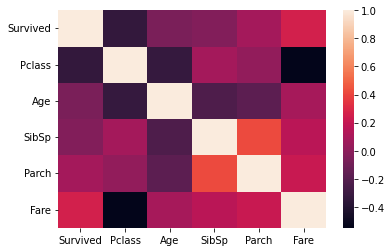

In [11]:
corr = trainencoded[trainencoded.columns[-6:161]].corr()
sns.heatmap(corr)

T-SNE reveals some pattern using for these columns: Survived,	Pclass,	 Age,	SibSp,	Parch,	Fare

In [25]:
from sklearn.manifold import TSNE
compressed = TSNE(n_components=2, learning_rate=10, min_grad_norm = 0.0005,
init='random', n_jobs = 4).fit_transform(trainencoded[trainencoded.columns[-6:161]])
tsne_ds = pd.concat([traindata["Survived"], pd.DataFrame(compressed)], axis = 1)

<AxesSubplot:xlabel='0', ylabel='1'>

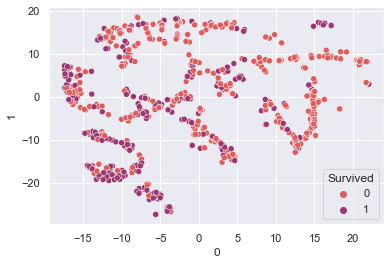

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt
palette = sns.color_palette("flare",2)
sns.set_theme(palette = palette)
f, ax = plt.subplots()
sns.scatterplot(data = tsne_ds, x = 0, y = 1, hue = "Survived")

Trying the same but with all columns. Some pattern still exist, it means that the SVM has potential for applying models

<AxesSubplot:xlabel='0', ylabel='1'>

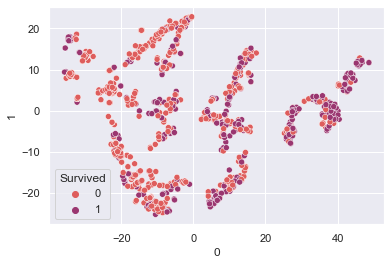

In [98]:
compressed_all = TSNE(n_components=2, learning_rate=10, min_grad_norm = 0.00005,
init='random', n_jobs = 4).fit_transform(trainencoded)
tsne_ds_all = pd.concat([traindata["Survived"], pd.DataFrame(compressed_all)], axis = 1)
sns.scatterplot(data = tsne_ds_all, x = 0, y = 1, hue = "Survived")

Detecting most important features by Random Forest Classifier:

<AxesSubplot:>

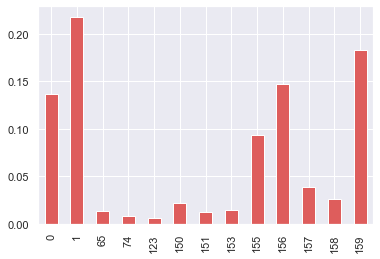

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
xtrain = trainencoded.drop(["Survived"], axis = 1)
ytrain = trainencoded["Survived"]
X_train, X_test, y_train, y_test = train_test_split(xtrain, ytrain, test_size =  0.2, random_state = 42)
model = RandomForestClassifier(max_features = 0.35, n_estimators = 25, min_samples_split = 7, max_depth = 20)
model.fit(X_train, y_train)
imp = model.feature_importances_

forest_importances = pd.Series(imp)
best_columns = xtrain.columns[forest_importances[forest_importances>0.100].index]
forest_importances[forest_importances>0.005].plot.bar()

The most important features:

<AxesSubplot:>

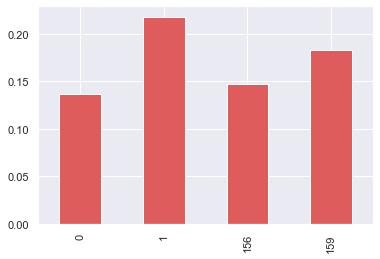

In [108]:
forest_importances[forest_importances>0.100].plot.bar()

Sex, age, and Fare gives the most powerful impact:

In [109]:
best_columns

Index(['Sex_female', 'Sex_male', 'Age', 'Fare'], dtype='object')

Score of this Random Forest model (it is quite good as a start point in most of cases):

In [110]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
accuracy_score( y_test, y_pred)

0.8100558659217877